# Figures for QPGA paper


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qpga.circuits import QFT_layer_count

In [9]:
num_qubits = [3,4,5,6,7,8]
num_layers_explicit = [QFT_layer_count(n, include_swap=True) for n in num_qubits]
num_layers_SGD = [7, 11] + [25, 40, 55, 70] # last bit are made up, will fill in when computations finish

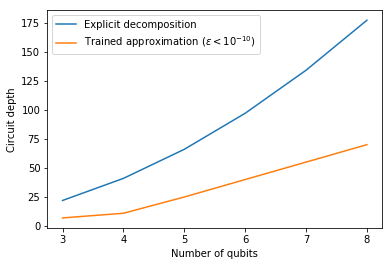

In [12]:
plt.plot(num_qubits, num_layers_explicit, label="Explicit decomposition")
plt.plot(num_qubits, num_layers_SGD, label="Trained approximation ($\epsilon < 10^{-10}$)")
plt.xlabel("Number of qubits")
plt.ylabel("Circuit depth")
plt.legend()
# plt.savefig("circuit_depth.png")
plt.show()